In [3]:
!pip install nltk
!pip install python-docx
!pip install transformers sentencepiece
!pip install rouge
!pip install pythainlp



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 244.3/244.3 kB 15.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.9/17.9 MB 81.0 MB/s eta 0:00:00


In [4]:
from nltk.cluster.util import cosine_distance
import numpy as np
import networkx as nx
import pandas as pd

import docx
from docx.enum.text import WD_COLOR_INDEX

import rouge

from transformers import AutoTokenizer, AutoModel

from pythainlp.tokenize import word_tokenize

In [5]:
model_name = "airesearch/wangchanberta-base-att-spm-uncased"
model = AutoModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/546 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/423M [00:00<?, ?B/s]

In [6]:
tokenizer = AutoTokenizer.from_pretrained(model_name)


tokenizer_config.json:   0%|          | 0.00/282 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/905k [00:00<?, ?B/s]

In [7]:
subword = list(tokenizer.vocab.keys())
df = pd.DataFrame(subword, columns =['subword'])
df.shape

(25004, 1)

In [8]:
tokenizer.tokenize('สวัสดีครับชาวโลก')


['▁', 'สวัสดีครับ', 'ชาวโลก']

In [10]:
inputs = tokenizer('สวัสดีครับชาวโลก', return_tensors='pt')

inputs

{'input_ids': tensor([[    5,    10,  5533, 15873,     6]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}

In [11]:
inputs['input_ids']


tensor([[    5,    10,  5533, 15873,     6]])

In [12]:
outputs = model(**inputs)

outputs[1].shape

torch.Size([1, 768])

In [13]:
outputs[1]


tensor([[-1.7417e-03, -1.8435e-02,  1.6773e-03,  3.2724e-02, -4.5005e-01,
          3.7407e-01,  2.3650e-01, -4.3904e-01,  5.3071e-01,  1.0394e-01,
          2.5839e-01, -2.1191e-01, -4.9980e-02, -4.0315e-01, -4.9616e-01,
          3.0455e-01, -3.9129e-01, -1.5483e-01,  1.1654e-01, -5.8820e-01,
          8.7398e-02, -9.9173e-03,  5.7244e-03,  2.9143e-02,  3.9419e-01,
          2.0283e-01,  3.5851e-01,  2.3526e-01,  2.4379e-01, -8.6311e-02,
          1.2132e-01, -6.0768e-01,  1.0238e-01, -5.0157e-01,  4.9279e-01,
          3.5147e-02,  2.9007e-01, -9.7012e-02, -1.0634e-01,  2.5652e-01,
         -1.8373e-01,  6.6176e-02, -9.7856e-02, -2.6775e-01, -1.5677e-01,
          1.9742e-01,  3.0807e-01, -3.6781e-01, -1.7245e-01,  2.3263e-01,
          2.7887e-01,  1.8814e-01, -1.7076e-01, -9.1210e-03,  9.2614e-02,
         -1.8831e-02, -1.5682e-02,  1.5432e-01,  2.3732e-02, -1.9179e-01,
         -9.1010e-02, -2.3388e-01, -2.0219e-01, -1.9506e-01,  1.0827e-01,
         -9.5903e-02, -4.1160e-02, -3.

In [14]:
file_name = 'road_comments.txt'

with open(file_name, 'r') as file:
    corpus = file.read().splitlines()

print(corpus)

['มีการลาดยางใหม่บนถนนเสนานิคม ทำให้ทางม้าลายบริเวณปากซอยเสนานิคม 26 หายไปตั้งแต่ช่วงก่อนปีใหม่', '', 'ช่วงนี้ข้ามถนนบริเวณนี้ยากกว่าเดิมมากครับ จากปกติมีทางม้าลายก็ข้ามลำบากอยู่แล้ว', '', 'ขอรบกวนเร่งรัดตีเส้นทางม้าลายให้ผู้ที่ต้องข้ามถนนบริเวณนี้ด้วยครับ ขอบคุณครับ', 'ซอยลาดพร้าว29 ผู้คนในซอยจอดรถทางฝั่งซ้ายบริเวณที่ไม่ชนตรงกับรั้วบ้านผู้อื่นด้านซ้ายมือ แต่ปัจจุบันมีการทำกรวยและถังขยะที่เทปูนใส่ไว้มาตั้งไม่ให้รถจอดทั้งๆที่ไม่ใช่บริเวณรั้ว ทำให้เกิดความยุ่งยากและอันตรายจากถังขยะใส่ปูน', 'ต้องการให้ช่วยปรับปรุงพื้นผิวทางสัญจรตลอดทั้งแนวทางประชาชนเดิน และแนวทางรถจักรยานยนต์วิ่ง ในตรอกศาลเจ้าพ่อกวนอู ซึ่งอยู่ข้าง MaKro สาทร ริมถนนนราธิวาสราชนครินทร์ เขตสาทร กทม เนื่องจากเป็นหลุมเป็นบ่อ ทางไม่เรียบ เคยมาซ่อมแซมบางจุด แต่ไม่นาน ก็สภาพเหมือนเดิม', 'ทางริมคลองมืด', 'ถนนเส้นจรัญสนิทวงศ์ตั้งแต่ 84/1เป็นต้นไป ฝั่งขาเข้าอนุสาวรีย์ ไฟบนถนนที่เป็นไฟใช้สัญจรไปมาไม่ติดมืดมากบริเวณฝั่งตรงข้ามติดหมดแต่ฝั่งขาเข้าอนุสาวรีย์ไฟไม่ติดเลยมืดไปจนถึงโลตัสบางพลัด เป็นนักศึกษาซึ่งใช้รถสัญจรไปมาซึ่งมันดูน่ากลัวเ

In [15]:
sentences = [s.strip() for s in corpus]


In [16]:
sentence_size = len(sentences)
sentence_size

181

In [17]:
sentences_tokens = [tokenizer(s, return_tensors="pt") for s in sentences]


In [18]:
sentences_encode = [model(**token) for token in sentences_tokens]

len(sentences_encode)

181

In [19]:
sentences_encode[0][1].shape


torch.Size([1, 768])

In [20]:
sentences_vec = [np.squeeze(vec[1].detach().numpy()) for vec in sentences_encode]

sentences_vec[0].shape

(768,)

In [21]:
def build_similarity_matrix(sentences):
    similarity_matrix = np.zeros((len(sentences), len(sentences)))

    for idx1 in range(len(sentences)):
        for idx2 in range(len(sentences)):
            if idx1 == idx2: #ignore if both are same sentences
                continue
            similarity_matrix[idx1][idx2] = sentence_similarity(sentences[idx1], sentences[idx2])

    return similarity_matrix

In [22]:
def sentence_similarity(sent1, sent2):
    return 1 - cosine_distance(sent1, sent2)

In [25]:
sentence_similarity_martix = build_similarity_matrix(sentences_vec)

sentence_similarity_martix.shape

(181, 181)

In [26]:
sentence_similarity_martix


array([[0.        , 0.42343339, 0.43617475, ..., 0.55636869, 0.20997643,
        0.42011509],
       [0.42343339, 0.        , 0.4595663 , ..., 0.65584481, 0.35003023,
        0.4803751 ],
       [0.43617475, 0.4595663 , 0.        , ..., 0.48397335, 0.24728997,
        0.39508562],
       ...,
       [0.55636869, 0.65584481, 0.48397335, ..., 0.        , 0.29364052,
        0.43707477],
       [0.20997643, 0.35003023, 0.24728997, ..., 0.29364052, 0.        ,
        0.28418408],
       [0.42011509, 0.4803751 , 0.39508562, ..., 0.43707477, 0.28418408,
        0.        ]])

In [27]:
sentence_similarity_graph = nx.from_numpy_array(sentence_similarity_martix)


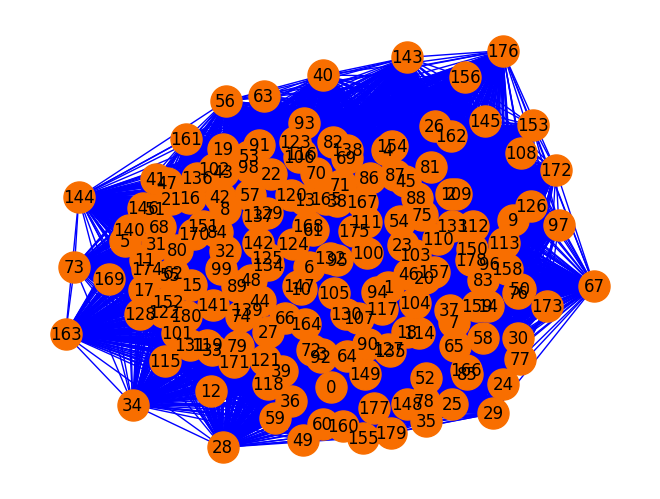

In [28]:
pos = nx.spring_layout(sentence_similarity_graph, seed=999)

nx.draw(sentence_similarity_graph,
        pos=pos, node_size=500,
        node_color='#f86e00',
        edge_color='blue',
        with_labels=True,
        width=1)

In [29]:
nx.get_edge_attributes(sentence_similarity_graph,'weight')


{(0, 1): 0.42343338560636756,
 (0, 2): 0.4361747452266289,
 (0, 3): 0.42343338560636756,
 (0, 4): 0.4406673317972334,
 (0, 5): 0.33713837241151157,
 (0, 6): 0.41843298896612413,
 (0, 7): 0.31506455463704675,
 (0, 8): 0.3256008532071908,
 (0, 9): 0.47517909591437557,
 (0, 10): 0.4559699463817468,
 (0, 11): 0.4402227726180298,
 (0, 12): 0.3580615455505073,
 (0, 13): 0.4496911481326583,
 (0, 14): 0.5563686927790801,
 (0, 15): 0.35015874255202917,
 (0, 16): 0.3583152578071438,
 (0, 17): 0.4295174229360448,
 (0, 18): 0.42343338560636756,
 (0, 19): 0.39391979964589297,
 (0, 20): 0.42343338560636756,
 (0, 21): 0.29905427461680234,
 (0, 22): 0.29707034615480343,
 (0, 23): 0.5467031691486612,
 (0, 24): 0.19054361505387352,
 (0, 25): 0.19805570442012144,
 (0, 26): 0.28182984201556205,
 (0, 27): 0.5831435623785872,
 (0, 28): 0.4157304009446081,
 (0, 29): 0.22973594346726545,
 (0, 30): 0.17472438759629605,
 (0, 31): 0.2841812457898738,
 (0, 32): 0.3605133976610708,
 (0, 33): 0.41165870430291573,
 

In [30]:
pos = nx.spring_layout(sentence_similarity_graph, seed=999)

scores = nx.pagerank(sentence_similarity_graph)

scores

{0: 0.004915147549831699,
 1: 0.0063289019976652695,
 2: 0.005182383660574214,
 3: 0.0063289019976652695,
 4: 0.005458315322790996,
 5: 0.005968392794694047,
 6: 0.006787841640300927,
 7: 0.004295065907183373,
 8: 0.006101805324932717,
 9: 0.004756863685306694,
 10: 0.006589806129048079,
 11: 0.0060913428177527705,
 12: 0.004589417190732556,
 13: 0.005823961575323435,
 14: 0.0055439711011240605,
 15: 0.006160672609676285,
 16: 0.006437261542483033,
 17: 0.006410844252186696,
 18: 0.0063289019976652695,
 19: 0.006211359267310501,
 20: 0.0063289019976652695,
 21: 0.005853440009753074,
 22: 0.006078031792211995,
 23: 0.0057243316731637175,
 24: 0.0043565639178629705,
 25: 0.004518258705389435,
 26: 0.00426597344832218,
 27: 0.0058669132223355385,
 28: 0.003115387777191057,
 29: 0.003852678718414133,
 30: 0.004403857587939637,
 31: 0.006101093454386146,
 32: 0.006574553547321562,
 33: 0.005871328148496383,
 34: 0.003182916035310539,
 35: 0.004481528057116332,
 36: 0.0045580437913820045,
 3

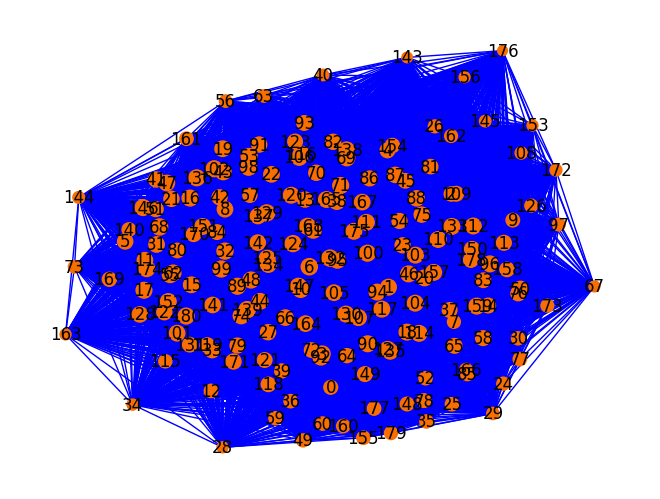

In [31]:
size = [v * 20000 for v in scores.values()]

nx.draw(sentence_similarity_graph,
        pos=pos,
        node_color='#f86e00',
        edge_color='blue',
        with_labels=True,
        width=1,
        node_size=size)

In [32]:
ranked_sentence = sorted(((scores[i],s) for i, s in enumerate(sentences)), reverse=True)

ranked_sentence

[(0.006787841640300927,
  'ต้องการให้ช่วยปรับปรุงพื้นผิวทางสัญจรตลอดทั้งแนวทางประชาชนเดิน และแนวทางรถจักรยานยนต์วิ่ง ในตรอกศาลเจ้าพ่อกวนอู ซึ่งอยู่ข้าง MaKro สาทร ริมถนนนราธิวาสราชนครินทร์ เขตสาทร กทม เนื่องจากเป็นหลุมเป็นบ่อ ทางไม่เรียบ เคยมาซ่อมแซมบางจุด แต่ไม่นาน ก็สภาพเหมือนเดิม'),
 (0.006716322454785055,
  'เมื่อวานนี้ ทาง TraffyFondue ส่งเรื่องกลับมาว่ามีการแก้ไขการวางต้นไม้บนถนนหลังวัดสุทธิวราราม แต่เมื่อเช้านี้ ไปตรวจสอบผลงาน ปรากฏว่า งานยังไม่ได้รับการแก้ไขให้ตรงประเด็น - ต้นไม้ยังคงวางกีดขวางเข้าพื้นที่ถนนเมตรกว่า ส่งผลให้รถยนต์ที่จอดค้างข้างทาง จอดเลยเส้นแบ่งถนนครับ - จุดนี้เอง อาจทำให้เกิดอุบัติเหตุ เพราะผมเองก็เกือบโดนรถชนเพราะไม่สามารถเดินทางเท้าได้ จะเดินบนถนนก็มีรถมาจอดเกยเกินเส้นแบ่งเลนถนนอีก - รบกวนแก้ไขให้ตรงจุดด้วยครับ - กราบขอร้องนะครับ เพราะถ้าเกิดอุบัติเหตุในจุดนี้จากความมักง่ายของผู้อยู่อาศัย มันไม่ส่งผลดีต่อทีมงานคุณเลยครับ เพราะมีการแจ้งการแก้ไขไปแล้วครับผม … กราบขอความช่วยเหลือด้วยครับ'),
 (0.006684920507954499,
  'อยากให้ทาง กทม พิจารณาทำลูกคลื่นชะลอความเร็ว

In [33]:
ranked_sentence[0][1]


'ต้องการให้ช่วยปรับปรุงพื้นผิวทางสัญจรตลอดทั้งแนวทางประชาชนเดิน และแนวทางรถจักรยานยนต์วิ่ง ในตรอกศาลเจ้าพ่อกวนอู ซึ่งอยู่ข้าง MaKro สาทร ริมถนนนราธิวาสราชนครินทร์ เขตสาทร กทม เนื่องจากเป็นหลุมเป็นบ่อ ทางไม่เรียบ เคยมาซ่อมแซมบางจุด แต่ไม่นาน ก็สภาพเหมือนเดิม'

In [34]:
top_n = round(sentence_size*0.2)

top_n

36

In [36]:
sum_text = ''
for i in range(top_n):
  sum_text = sum_text + '\n' + ranked_sentence[i][1]

In [37]:
sum_list = []
for i in range(top_n):
  sum_list.append(ranked_sentence[i][1])

In [38]:
original_text = ''
for st in sentences:
  original_text = original_text + '\n' + st

In [40]:
print('\ Text: \n', sum_text)


\ Text: 
 
ต้องการให้ช่วยปรับปรุงพื้นผิวทางสัญจรตลอดทั้งแนวทางประชาชนเดิน และแนวทางรถจักรยานยนต์วิ่ง ในตรอกศาลเจ้าพ่อกวนอู ซึ่งอยู่ข้าง MaKro สาทร ริมถนนนราธิวาสราชนครินทร์ เขตสาทร กทม เนื่องจากเป็นหลุมเป็นบ่อ ทางไม่เรียบ เคยมาซ่อมแซมบางจุด แต่ไม่นาน ก็สภาพเหมือนเดิม
เมื่อวานนี้ ทาง TraffyFondue ส่งเรื่องกลับมาว่ามีการแก้ไขการวางต้นไม้บนถนนหลังวัดสุทธิวราราม แต่เมื่อเช้านี้ ไปตรวจสอบผลงาน ปรากฏว่า งานยังไม่ได้รับการแก้ไขให้ตรงประเด็น - ต้นไม้ยังคงวางกีดขวางเข้าพื้นที่ถนนเมตรกว่า ส่งผลให้รถยนต์ที่จอดค้างข้างทาง จอดเลยเส้นแบ่งถนนครับ - จุดนี้เอง อาจทำให้เกิดอุบัติเหตุ เพราะผมเองก็เกือบโดนรถชนเพราะไม่สามารถเดินทางเท้าได้ จะเดินบนถนนก็มีรถมาจอดเกยเกินเส้นแบ่งเลนถนนอีก - รบกวนแก้ไขให้ตรงจุดด้วยครับ - กราบขอร้องนะครับ เพราะถ้าเกิดอุบัติเหตุในจุดนี้จากความมักง่ายของผู้อยู่อาศัย มันไม่ส่งผลดีต่อทีมงานคุณเลยครับ เพราะมีการแจ้งการแก้ไขไปแล้วครับผม … กราบขอความช่วยเหลือด้วยครับ
อยากให้ทาง กทม พิจารณาทำลูกคลื่นชะลอความเร็วภายในซอย สุคนธสวัสดิ์ 3 แยก 3 ( ซอยทองนวล 2) เนื่องจากซอยดังกล่าว  เป็นทางเช

In [41]:

with open('sum_text.txt', 'w', encoding='utf-8') as f:
    f.write(sum_text)